# Two neuron dynamics analysis

In this notebook we are going to study the behaviour of synaptical modelling in two conductance based neuron models  

In [1]:
import numpy as np
from scipy.integrate import odeint
from functools import partial

In [2]:
# global single cell parameters
ena, ek, el, esyn = 60, -90, -80, 0
gna, gk, gl = 20, 10, 8 
C, I = 1, 0
vmaxm, vmaxn = -20, -25
km, kn = 15, 5
taun, taus = 1, 5 

# global two cell parameters
vt, vs = 2, 5
As = 1
b1, b2 = 0.25, 0.1
I1, I2 = 0, 0
# g_ext, g_exc, g_inh = 3, 1, 0.1

In [3]:
# Excitation functions
def spike_train(d, rate, dt):
    """ Generates Poisson delta train
    Params:
    d (int): duration in milliseconds of the train
    rate (int): how many firings per second (Hz)
    dt (float): time differential used in the simulation REPLACE THIS IS NOW D/N AS EVERYTHING ELSE!
    Returns:
    result (np.array) with the indexes of the spikes
    """
    n = int(d/dt)
    spikes = np.random.rand(n) < rate/1000*dt # We divide by 1000 bc rate is in Hz
    index = np.where(spikes)[0]
    return index*dt

def alfa(t):
    """ Enveloping function
    For each spike we fire one of these
    """
    return 1/taus**2*t*np.e**(-t/taus)

def step(t):
    """ Returns 0 if t less than 0
    """
    return 1 if t > 0 else 0

def opt_gsyn(t, train):
    """ Excitation function
    Takes a Poisson delta train and generates a sum of enveloping functions (alphas)
    """
    result = 0
    reduced_train = train[(train > (t-40)) & (train < t)]
    for it in reduced_train:
        result += alfa(t-it)*step(t-it)
    return result

# ODE time derivative and assistant functions
def minf(V):
    return 1/(1+np.e**(-(V-vmaxm)/km))

def ninf(V):
    return 1/(1+np.e**(-(V-vmaxn)/kn))

def fpre(v):
    return 1./(1 + np.e**(-(v-vt)/vs))

# Parametric time derivative (Add all the parameters you wanna play with in the arguments of the function)
def twoneurons(X, t, spikes, g_ext, g_inh, g_exc, I1=0, I2=0, cross=False, lamb=1):
    V1, V2, n1, n2, s1, s2 = X
    
    if cross:
        A,B=V2,V1
    else:
        A,B=V1,V2
   
    dV1dt = (I1 - gl*(V1-el) - gna*minf(V1)*(V1-ena) - gk*n1*(V1-ek) - g_inh*s2*(A - (-80)) - g_ext*opt_gsyn(t, spikes)*(A-0))/C # 
    dn1dt = (ninf(V1) - n1)/taun
    
    dV2dt = (I2 - gl*(V2-el) - gna*minf(V2)*(V2-ena) - gk*n2*(V2-ek) - g_exc*s1*(B - 0))/C
    dn2dt = (ninf(V2) - n2)/taun
    
    ds1dt = As * fpre(V1)*(1-s1) - lamb*b1*s1
    ds2dt = As * fpre(V2)*(1-s2) - lamb*b2*s2
    
    return [dV1dt, dV2dt, dn1dt, dn2dt, ds1dt, ds2dt]
    

In [4]:
# This is example time integration of the model
d, n = 200, 500
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 0, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

**INTRODUCING MODULAR PLOTS**

This means plots as a function cause now we are going to do lots of plots this is convenient for mental sanity

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [6]:
def plot_spikesandgsyn(axis, spikes, time_span):
    # Plot spike lines
    for t in spikes:
        l1 = axis.axvline(x=t, color='darkblue', linestyle='dashed', linewidth=1, label='spike')

    # Compute synaptic excitation
    results = np.zeros(time_span.shape[0])
    for it, t in enumerate(time_span):
        results[it] = (opt_gsyn(t, spikes))

    # And plot it
    l2, = axis.plot(time_span,results, c='r', alpha=0.8, label='g_syn')

    # This is a custom legend (might export this to a function in the future)
    lines = [l1,l2]
    axis.legend(lines, [l.get_label() for l in lines])

    axis.set(ylabel="$g_{syn}$ (mS)",xlabel="time (ms)")
    axis.grid()
    
    return axis

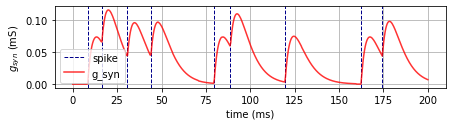

In [7]:
# Example spike and gsyn plot
d, n = 200, 500
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

fig, ax = plt.subplots(1,1, figsize=(7,1.5))

plot_spikesandgsyn(axis=ax, spikes=spikes, time_span=time_span)

fig.show()

In [8]:
def plot_neuron(axis, time_span, signals, n_num, set_time=False):
    
    # Plotting signal 1 in left axis and signal 2 in right axis
    l1, = axis.plot(time_span, signals[0] , c='tab:blue', label=f'$V_{{{n_num}}}$', lw=2.0)
    axis2 = axis.twinx()
    axis2.set(ylabel=f'$s_{{{n_num}}}$')
    l2, = axis2.plot(time_span, signals[1] , c='tab:orange', label=f'$s_{{{n_num}}}$', alpha=0.8)

    # This sets up the legend
    lines = [l1,l2]
    axis.legend(lines, [l.get_label() for l in lines])
    
    # Set labels
    axis.set(ylabel=f"$V_{{{n_num}}}$ (mv)")
    if set_time:
        axis.set(xlabel="time (ms)")
    
    # Activate grid
    axis.grid()

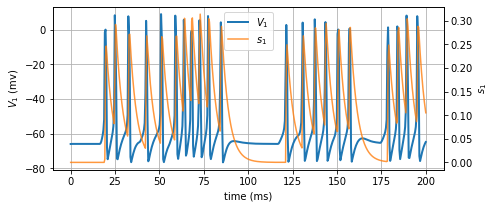

In [9]:
# Example spike and gsyn plot
d, n = 200, 500
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

fig, ax = plt.subplots(1,1, figsize=(7,3))

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 0, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

plot_neuron(axis=ax, time_span=time_span, signals=[run[:,0],run[:,4]], n_num=1, set_time=True)

fig.show()

In [10]:
# Now a plot that actually means something
def plot_completetwoneurons(time_span, spikes, run):
    fig, ax = plt.subplots(3,1, figsize=(7,7), sharex=True, gridspec_kw={ 'height_ratios': [2, 2, 1],
                                                                      'wspace':0, 
                                                                      'hspace':0.2 })
    # This is to set same formatting (look good!)
    for a in ax: a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 

    plot_spikesandgsyn(axis=ax[2], spikes=spikes, time_span=time_span)

    plot_neuron(axis=ax[0], time_span=time_span, signals=[run[:,0],run[:,4]], n_num=1)

    plot_neuron(axis=ax[1], time_span=time_span, signals=[run[:,1],run[:,5]], n_num=2)

    # Set big title
    pars = [f'{name}={params[name]}' for name in list(params.keys())[1:]]
    fig.suptitle(f'Temporal run two neuron model with {pars}', y=0.93)

    fig.tight_layout()
    
    return fig, ax

<ipython-input-10-b52a023f2686>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


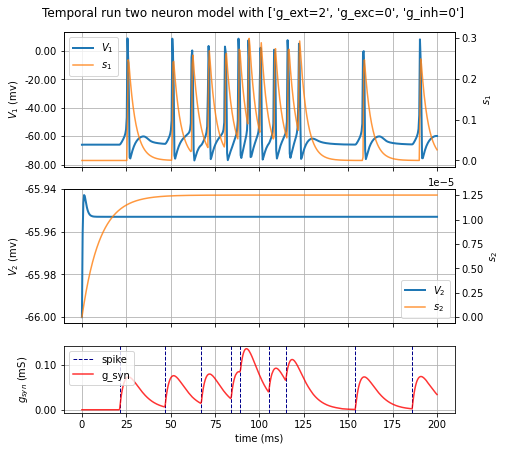

In [11]:
# Example meaningful plot
d, n = 200, 500
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 0, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run)

fig.show()

**Now the experiments**

We set up a fixed spike train and let's see

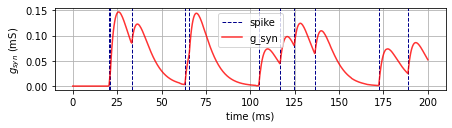

In [12]:
d, n = 200, 500
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

fig, ax = plt.subplots(1,1, figsize=(7,1.5))
plot_spikesandgsyn(axis=ax, spikes=spikes, time_span=time_span)
fig.show()

Standard runs with different synaptical parameters

<ipython-input-10-b52a023f2686>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


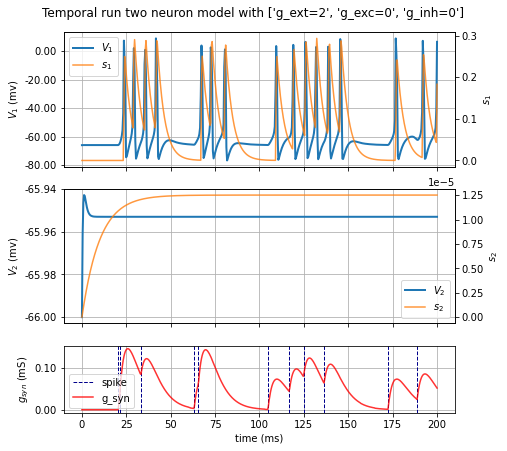

In [13]:
# FIRST CASE SYNAPTICAL TO ZERO
# expected behaviour as no synaptical behavior
params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 0, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run)

fig.show()

<ipython-input-10-b52a023f2686>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


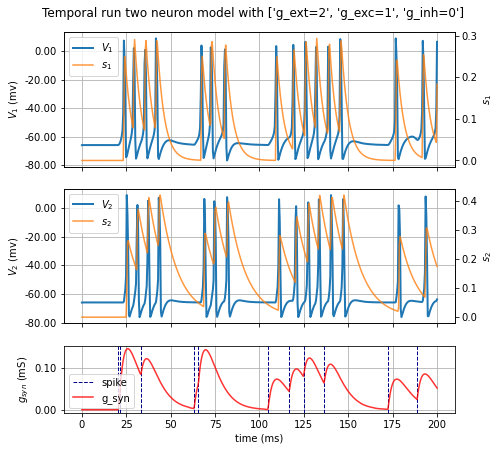

In [14]:
# SECOND CASE SYNAPTICAL EXCITATION TO 1
# It is weird that v1 and v2 are the exact same

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 0}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run)

fig.show()

<ipython-input-10-b52a023f2686>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


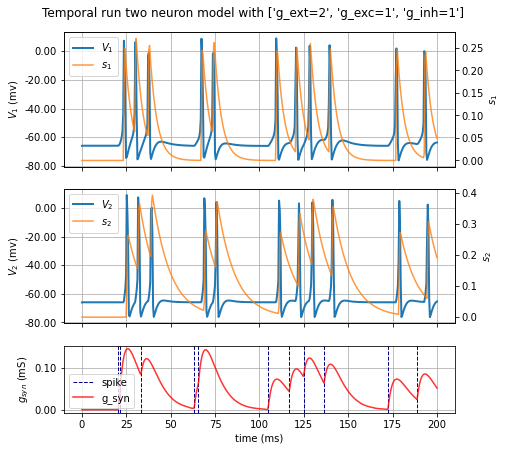

In [15]:
# THIRD CASE SYNAPTICAL EXCITATION AND INHIBITION TO 1
# Realize that now there are less spikes, but still same v1 and v2 behaviour

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1}

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run)

fig.show()

What if we add an external current $I_{app}$?

<ipython-input-10-b52a023f2686>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


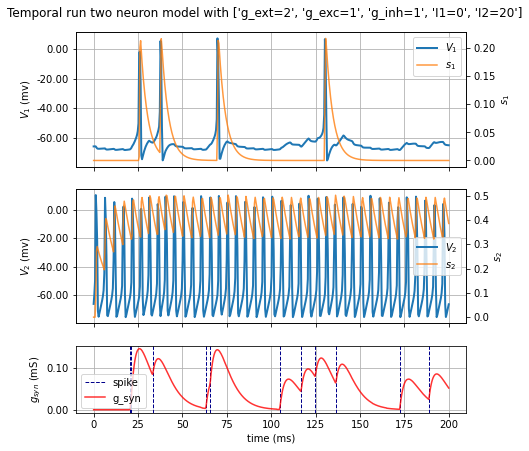

In [16]:
# FIRST EXPERIMENT: HIGH CURRENT IN I2 WITH COMPLETE SYNAPTICAL ACTIVITY
# expected behaviour as N2 depresses neuron 1 a lot
params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1,
          'I1':0,
          'I2':20,
         }

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run)

fig.show()

<ipython-input-10-b52a023f2686>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


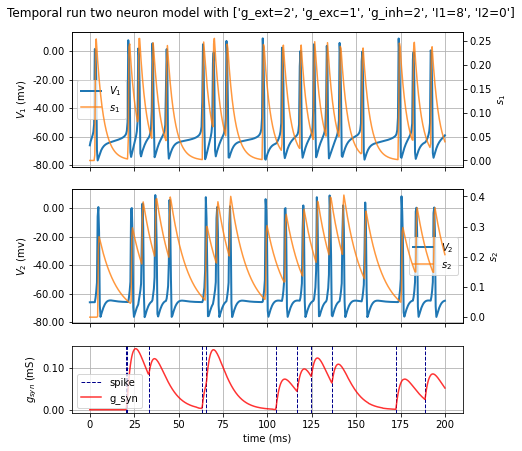

In [17]:
# SECOND EXPERIMENT: MEDIUM CURRENT IN I1 WITH COMPLETE SYNAPTICAL ACTIVITY
# nothing remarcable N1 excites N2 and we see everything in N2
# if we vary g_inh we see that controls the number of spikes in both neurons
params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 2,
          'I1':8,
          'I2':0,
         }

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run)

fig.show()

What if we cross V1 and V2 voltage for excitation? Does it make sense?

<ipython-input-10-b52a023f2686>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


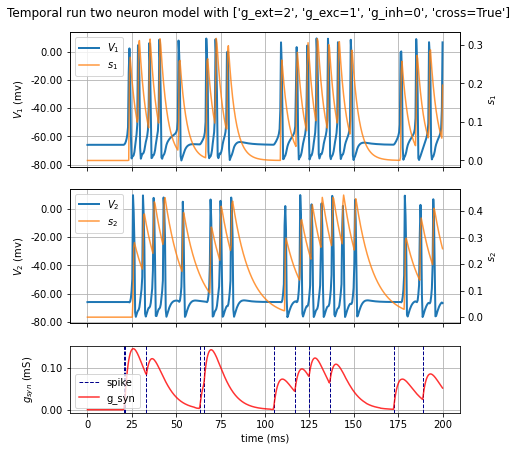

In [18]:
# FIRST EXPERIMENT: CROSSED VOLTAGES ONLY EXCITATION
# It looks like they replicate
# second though can't cross s1 and s2 as the second starts at zero it would cancel everything
params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 0,
          'cross': True,
         }

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run)

fig.show()

<ipython-input-10-b52a023f2686>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


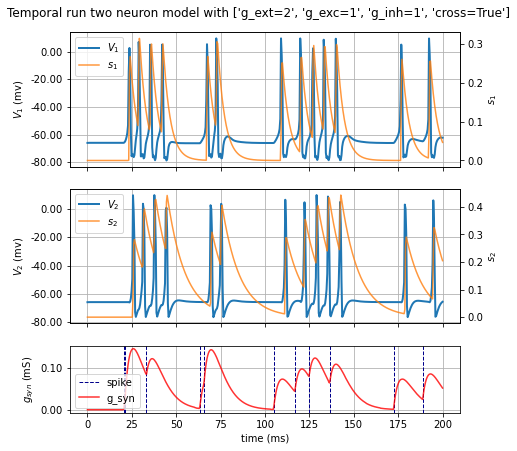

In [19]:
# SECOND EXPERIMENT: CROSSED VOLTAGES COMPLETE SYNAPSE 
# I am starting to think it doesn't make much sense
# It divides by two the number of spikes in both cases
params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1,
          'cross': True,
         }

y0 = [-66,-66,0,0,0,0]

run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

fig, ax = plot_completetwoneurons(time_span, spikes, run)

fig.show()

**Exercise A** Try different values of g_inh and comment the results

In [20]:
# Three scenarios with three different g_inh
params = [{'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 0,
          },
          {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1,
          },
          {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 2,
          }]

y0 = [-66,-66,0,0,0,0]
          
d, n = 300, 3000
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

store = np.zeros((3,n,6))
          
for ix, scenario in enumerate(params):
    store[ix, :] = odeint(partial(twoneurons, **scenario), y0=y0, t=time_span)

<ipython-input-35-223f5e76dbc6>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


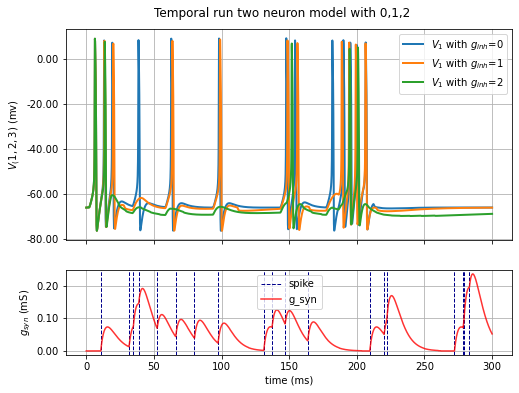

In [35]:
fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=True, gridspec_kw={ 'height_ratios': [2.5, 1],
                                                                      'wspace':0, 
                                                                      'hspace':0.2 })
# This is to set same formatting (look good!)
for a in ax: a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
        
colors = ['tab:blue','tab:orange','tab:green']
for i in range(3):
    ax[0].plot(time_span, store[i,:,0] , c=colors[i], label=f"$V_1$ with $g_{{inh}}$={[0,1,2][i]}", lw=2.0)

ax[0].legend()
# Set labels
ax[0].set(ylabel=f"$V_{1,2,3}$ (mv)")
# Activate grid
ax[0].grid()

plot_spikesandgsyn(axis=ax[1], spikes=spikes, time_span=time_span)

# Set big title
fig.suptitle(f'Temporal run two neuron model with 0,1,2', y=0.93)

fig.tight_layout()

In [22]:
# Let's zoom in that messy area...
t1, t2 = 30, 60
i1,i2 = int(t1*n/d),int(t2*n/d)
mod_spikes = spikes[(t1<spikes)&(spikes<t2)]

<ipython-input-23-992c71be8ee2>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


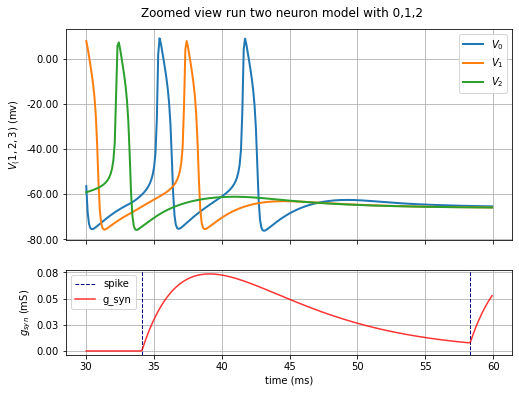

In [23]:
fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=True, gridspec_kw={ 'height_ratios': [2.5, 1],
                                                                      'wspace':0, 
                                                                      'hspace':0.2 })
# This is to set same formatting (look good!)
for a in ax: a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
        
colors = ['tab:blue','tab:orange','tab:green']
for i in range(3):
    ax[0].plot(time_span[i1:i2], store[i,i1:i2,0] , c=colors[i], label=f"$V_1$ with $g_{{inh}}$={[0,1,2][i]}", lw=2.0)

ax[0].legend()
# Set labels
ax[0].set(ylabel=f"$V_{1,2,3}$ (mv)")
# Activate grid
ax[0].grid()

plot_spikesandgsyn(axis=ax[1], spikes=mod_spikes, time_span=time_span[i1:i2])

# Set big title
fig.suptitle(f'Zoomed view run two neuron model with 0,1,2', y=0.93)

fig.tight_layout()

**Exercise B** Study the impact of changing time constant $1/\beta_i$ by a parameter $\lambda$

In [24]:
# Three scenarios with three different g_inh
params = [{'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1,
          'lamb': 1,
          },
          {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1,
          'lamb': 0.5,
          },
          {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 1,
          'lamb': 0.1,
          }]

y0 = [-66,-66,0,0,0,0]
          
d, n = 300, 3000
time_span = np.linspace(0.0, d, n)
spikes = spike_train(d, 50, d/n)

store = np.zeros((3,n,6))
          
for ix, scenario in enumerate(params):
    store[ix, :] = odeint(partial(twoneurons, **scenario), y0=y0, t=time_span)

<ipython-input-36-b476e59c64a4>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


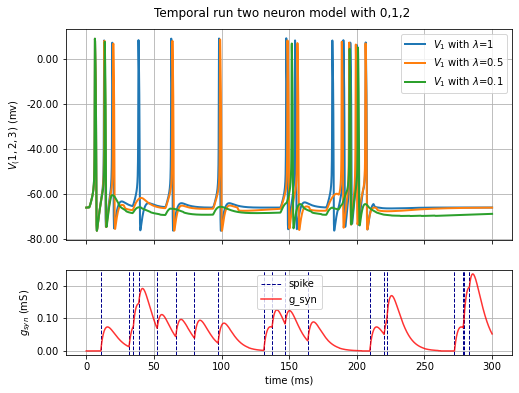

In [36]:
fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=True, gridspec_kw={ 'height_ratios': [2.5, 1],
                                                                      'wspace':0, 
                                                                      'hspace':0.2 })
# This is to set same formatting (look good!)
for a in ax: a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
        
colors = ['tab:blue','tab:orange','tab:green']
for i in range(3):
    ax[0].plot(time_span, store[i,:,0] , c=colors[i], label=f"$V_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=2.0)

ax[0].legend()
# Set labels
ax[0].set(ylabel=f"$V_{1,2,3}$ (mv)")
# Activate grid
ax[0].grid()

plot_spikesandgsyn(axis=ax[1], spikes=spikes, time_span=time_span)

# Set big title
fig.suptitle(f'Temporal run two neuron model with 0,1,2', y=0.93)

fig.tight_layout()

In [37]:
# Let's zoom in that messy area...
t1, t2 = 10, 110
i1,i2 = int(t1*n/d),int(t2*n/d)
mod_spikes = spikes[(t1<spikes)&(spikes<t2)]

<ipython-input-38-1a2a88314f48>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


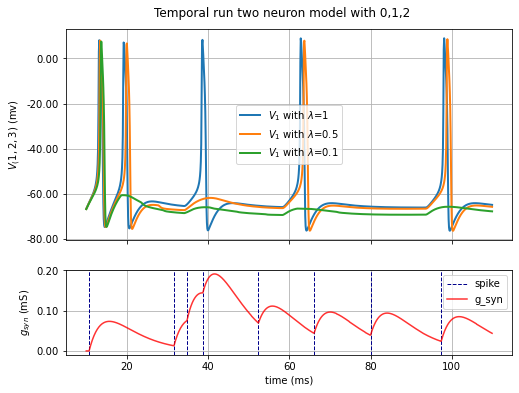

In [38]:
fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=True, gridspec_kw={ 'height_ratios': [2.5, 1],
                                                                      'wspace':0, 
                                                                      'hspace':0.2 })
# This is to set same formatting (look good!)
for a in ax: a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
        
colors = ['tab:blue','tab:orange','tab:green']
for i in range(3):
    ax[0].plot(time_span[i1:i2], store[i,i1:i2,0] , c=colors[i], label=f"$V_1$ with $\lambda$={[1,0.5,0.1][i]}", lw=2.0)

ax[0].legend()
# Set labels
ax[0].set(ylabel=f"$V_{1,2,3}$ (mv)")
# Activate grid
ax[0].grid()

plot_spikesandgsyn(axis=ax[1], spikes=mod_spikes, time_span=time_span[i1:i2])

# Set big title
fig.suptitle(f'Temporal run two neuron model with 0,1,2', y=0.93)

fig.tight_layout()